In [773]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error

In [774]:
device = torch.device('cpu')
device

device(type='cpu')

In [775]:
ticker = 'AAPL'
df = yf.download(ticker,'2020-01-01')
dff = yf.download(ticker,'2020-01-01')

/var/folders/yv/q6qk8hl51wl7w995rj9w0kx80000gn/T/ipykernel_31007/1479239476.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/yv/q6qk8hl51wl7w995rj9w0kx80000gn/T/ipykernel_31007/1479239476.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dff = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [776]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538506,72.598884,71.292296,71.545882,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065163,72.671356,71.845385,72.415353,108872000
2020-01-08,73.224411,73.526303,71.768086,71.768086,132079200
...,...,...,...,...,...
2025-09-15,236.699997,238.190002,235.029999,237.000000,42699500
2025-09-16,238.149994,241.220001,236.320007,237.179993,63421100


<Axes: xlabel='Date'>

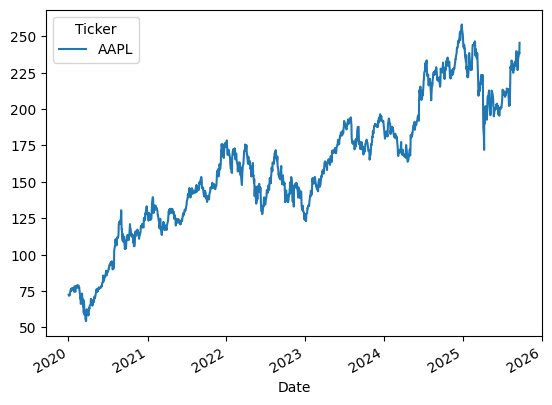

In [777]:
df.Close.plot()

In [778]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [779]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,-1.932296,72.598884,71.292296,71.545882,135480400
2020-01-03,-1.947867,72.594055,71.608685,71.765667,146322800
2020-01-06,-1.935229,72.444313,70.703005,70.954181,118387200
2020-01-07,-1.942747,72.671356,71.845385,72.415353,108872000
2020-01-08,-1.917152,73.526303,71.768086,71.768086,132079200
...,...,...,...,...,...
2025-09-15,1.692283,238.190002,235.029999,237.000000,42699500
2025-09-16,1.724298,241.220001,236.320007,237.179993,63421100


In [780]:
dff

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538513,72.598892,71.292304,71.545890,135480400
2020-01-03,71.833282,72.594048,71.608677,71.765659,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065132,72.671325,71.845354,72.415322,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200
...,...,...,...,...,...
2025-09-15,236.699997,238.190002,235.029999,237.000000,42699500
2025-09-16,238.149994,241.220001,236.320007,237.179993,63421100


Can see Close price is now scaled

Goal is to be able to use data over any period of time to predict the stock price. So LSTM is best option

In [781]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

Each window has 30 days. It is a sliding window of stock Close values starting from day 0 to day 29. Keep doing this until there is no more room.

In [782]:
type(data)

numpy.ndarray

In [783]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, : -1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [784]:
y_train

tensor([[-1.7974],
        [-1.7970],
        [-1.8288],
        ...,
        [ 1.3411],
        [ 1.2595],
        [ 1.2924]])

Have our data in tensors

In [785]:
class PredictionModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel,self).__init__()

        self.num_layers =num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out

In [786]:
model = PredictionModel(input_dim=1, hidden_dim= 32, num_layers=2, output_dim=1).to(device)

In [787]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [788]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i,loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 0.8455193638801575
25 0.009726441465318203
50 0.0061411177739501
75 0.005311683751642704
100 0.004950241651386023
125 0.004636059515178204
150 0.004363357555121183
175 0.004135407507419586


In [789]:
model.eval()

y_test_pred = model(X_test)

In [790]:
print(y_test_pred)
print(y_test_pred.size())

tensor([[1.3117],
        [1.1631],
        [1.0344],
        [1.0460],
        [1.1506],
        [1.2507],
        [1.3016],
        [1.3541],
        [1.3766],
        [1.4116],
        [1.4407],
        [1.4446],
        [1.4441],
        [1.4389],
        [1.4102],
        [1.4206],
        [1.4383],
        [1.4557],
        [1.4427],
        [1.4688],
        [1.4781],
        [1.3995],
        [1.3198],
        [1.3125],
        [1.3131],
        [1.3194],
        [1.3161],
        [1.3483],
        [1.3723],
        [1.3750],
        [1.2881],
        [1.2374],
        [1.2870],
        [1.4358],
        [1.5012],
        [1.4817],
        [1.4616],
        [1.4384],
        [1.4399],
        [1.4486],
        [1.5133],
        [1.4705],
        [1.4313],
        [1.4036],
        [1.4105],
        [1.3586],
        [1.3770],
        [1.4515],
        [1.4862],
        [1.4704],
        [1.4951],
        [1.5415],
        [1.5381],
        [1.5262],
        [1.5491],
        [1

Need to inverse the scaler transformation and turn the tensor back into anumpy array, so we can compare the predictated data to the actual data

In [791]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [792]:
y_test_pred.shape

(282, 1)

In [793]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [794]:
train_rmse

2.845747947692871

In [795]:
test_rmse

5.764883518218994

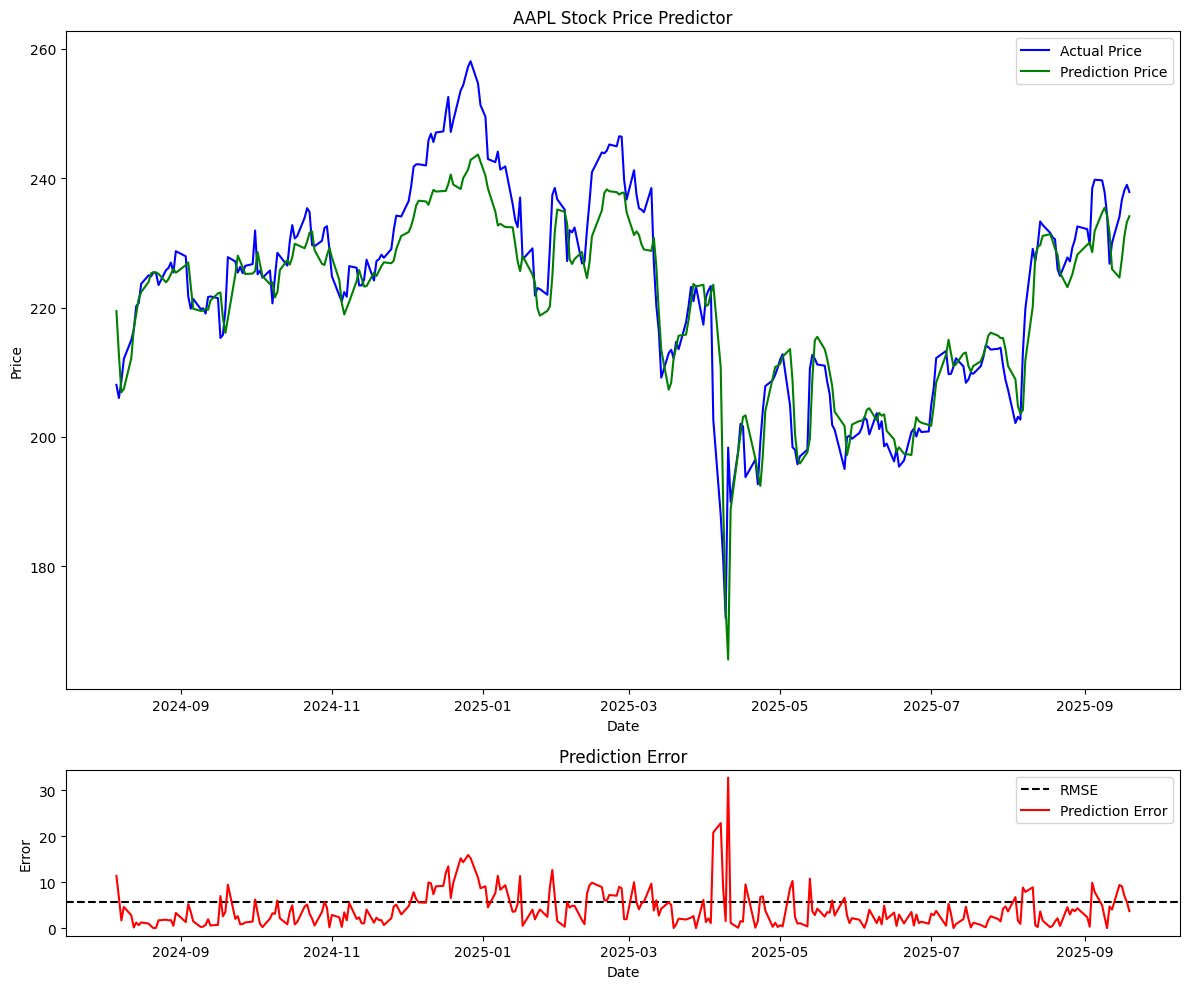

In [796]:
graph = plt.figure(figsize=(12,10))

gs = graph.add_gridspec(4,1)
axl = graph.add_subplot(gs[:3,0])

axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Prediction Price')
axl.legend()

plt.title(f"{ticker} Stock Price Predictor")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = graph.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'black', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'red', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [797]:
X_test

tensor([[[1.0351],
         [1.0555],
         [1.1473],
         ...,
         [1.3411],
         [1.2595],
         [1.2924]],

        [[1.0555],
         [1.1473],
         [1.1660],
         ...,
         [1.2595],
         [1.2924],
         [1.0599]],

        [[1.1473],
         [1.1660],
         [1.0896],
         ...,
         [1.2924],
         [1.0599],
         [1.0151]],

        ...,

        [[0.9414],
         [1.1692],
         [1.3187],
         ...,
         [1.5450],
         [1.6342],
         [1.6923]],

        [[1.1692],
         [1.3187],
         [1.5243],
         ...,
         [1.6342],
         [1.6923],
         [1.7243]],

        [[1.3187],
         [1.5243],
         [1.4821],
         ...,
         [1.6923],
         [1.7243],
         [1.7428]]])

In [799]:
print(X_test.size())

torch.Size([282, 29, 1])


In [798]:
X_test = scaler.inverse_transform(X_test.detach().cpu().numpy())

ValueError: Found array with dim 3, while dim <= 2 is required.

In [ ]:
X_test

array([[[1.035119  ],
        [1.0555345 ],
        [1.1472923 ],
        ...,
        [1.3411254 ],
        [1.2594652 ],
        [1.2923925 ]],

       [[1.0555345 ],
        [1.1472923 ],
        [1.1659514 ],
        ...,
        [1.2594652 ],
        [1.2923925 ],
        [1.059925  ]],

       [[1.1472923 ],
        [1.1659514 ],
        [1.0895591 ],
        ...,
        [1.2923925 ],
        [1.059925  ],
        [1.015143  ]],

       ...,

       [[0.94136333],
        [1.1691847 ],
        [1.3187128 ],
        ...,
        [1.5450137 ],
        [1.6342145 ],
        [1.6922829 ]],

       [[1.1691847 ],
        [1.3187128 ],
        [1.5242594 ],
        ...,
        [1.6342145 ],
        [1.6922829 ],
        [1.724298  ]],

       [[1.3187128 ],
        [1.5242594 ],
        [1.4820875 ],
        ...,
        [1.6922829 ],
        [1.724298  ],
        [1.7428448 ]]], shape=(282, 29, 1), dtype=float32)

In [ ]:
X_test = scaler.inverse_transform(X_test)  

ValueError: Found array with dim 3, while dim <= 2 is required.

In [ ]:
X_test

array([[[-0.06220452],
        [-0.05152893],
        [-0.05610421],
        ...,
        [ 0.06031117],
        [ 0.0659031 ],
        [ 0.06539473]],

       [[-0.05152893],
        [-0.05610421],
        [-0.05051218],
        ...,
        [ 0.0659031 ],
        [ 0.06539473],
        [ 0.05878604]],

       [[-0.05610421],
        [-0.05051218],
        [-0.06627148],
        ...,
        [ 0.06539473],
        [ 0.05878604],
        [ 0.06793661]],

       ...,

       [[ 3.5265906 ],
        [ 3.6859624 ],
        [ 3.7535748 ],
        ...,
        [ 3.3001144 ],
        [ 3.4798207 ],
        [ 3.474229  ]],

       [[ 3.6859624 ],
        [ 3.7535748 ],
        [ 3.8745658 ],
        ...,
        [ 3.4798207 ],
        [ 3.474229  ],
        [ 3.4500816 ]],

       [[ 3.7535748 ],
        [ 3.8745658 ],
        [ 3.7657754 ],
        ...,
        [ 3.474229  ],
        [ 3.4500816 ],
        [ 3.4010246 ]]], shape=(244, 29, 1), dtype=float32)

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

# flatten targets/preds to 1-D
y_true = to_np(y_test).reshape(-1)
y_hat  = to_np(y_test_pred).reshape(-1)

X_np   = scaler.inverse_transform(X_test)              


# Baselines
last        = X_np[:, -1, 0]                          # persistence
y_naive     = last
y_naive_ar1 = last + (last - X_np[:, -2, 0])          # carry-forward last change
y_sma30     = X_np[:, :, 0].mean(axis=1)              # simple moving average

# Metrics
rmse = lambda a,b: root_mean_squared_error(a, b)
mae  = lambda a,b: mean_absolute_error(a, b)

print("RMSE LSTM :", rmse(y_true, y_hat))
print("RMSE Naive:", rmse(y_true, y_naive))
print("RMSE AR1  :", rmse(y_true, y_naive_ar1))
print("RMSE SMA  :", rmse(y_true, y_sma30))

improve = 100 * (rmse(y_true, y_naive) - rmse(y_true, y_hat)) / rmse(y_true, y_naive)
print(f"Improvement vs Naive: {improve:.1f}%")

# Directional (up/down) accuracy vs last price
true_up = y_true > last
lstm_up = y_hat  > last
ar1_up  = y_naive_ar1 > last
print(f"Directional hit LSTM: {(lstm_up == true_up).mean()*100:.1f}%")
print(f"Directional hit AR1 : {(ar1_up  == true_up).mean()*100:.1f}%")

ValueError: Found array with dim 3, while dim <= 2 is required.